In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'c:\\Users\\USER\\Desktop\\컴퓨터비전개론\\Image Filtering'

In [3]:
jy = cv2.imread("Sample Images/jy31.jpg", cv2.IMREAD_GRAYSCALE)

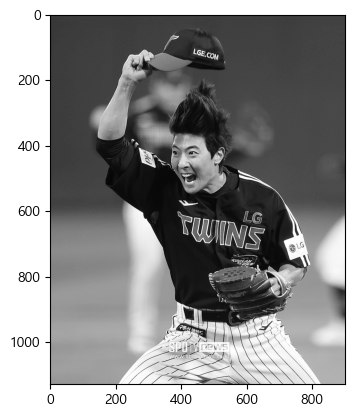

In [4]:
plt.imshow(jy, cmap="gray")

In [5]:
def padding(img, p_size):
    row, col = img.shape
    top = np.repeat([img[0]], repeats=p_size, axis=0) # top padding
    bottom = np.repeat([img[-1]], repeats=p_size, axis=0) # bottom padding
    img = np.vstack([top, img, bottom]) 
    img = np.insert(img, [col]*p_size, img[:,[col-1]], axis=1) # right padding
    img = np.insert(img, [1]*p_size, img[:,[0]], axis=1) # left padding
    return img

In [6]:
def cross_correlation_1d(img, kernel=None):
    processed_img = []
    filter_size = kernel.shape[0] # filter의 길이

    p_size = filter_size // 2 # padding의 크기
    padded_img = padding(img, p_size=p_size) # padding image
    row, col = padded_img.shape

    for i in range(p_size, row-p_size):
        temp  = []
        for j in range(p_size, col-p_size):
            if kernel.ndim == 1: temp.append(np.dot(kernel, padded_img[i, j-p_size:j+p_size+1]))
            else: temp.append(np.dot(np.ravel(kernel), padded_img[i-p_size:i+p_size+1, j]))
        processed_img.append(temp)
    return np.array(processed_img)

In [7]:
def cross_correlation_2d(img, kernel=None):
    processed_img = []
    filter_size = kernel.shape[0] # filter의 한 변의 길이 (MxM Kernel이라고 할 때 ..)

    p_size = filter_size // 2 # padding의 크기
    padded_img = padding(img, p_size=p_size) # padding image
    row, col = padded_img.shape

    for i in range(p_size, row-p_size):
        temp = []
        for j in range(p_size, col-p_size):
            temp.append(np.dot(kernel.ravel(), padded_img[i-p_size:i+p_size+1, j-p_size:j+p_size+1].ravel()))
        processed_img.append(temp)
    return np.array(processed_img)

In [8]:
def gaussian(i, j=0, sigma=1):
    return (1/(2*np.pi*sigma**2))*np.exp(-1*((i**2)+(j**2))/(2*sigma**2))

In [9]:
def get_gaussian_filter_1d(size, sigma=1):
    k_size = size // 2
    kernel = np.linspace(-k_size, k_size, size) # 1D kernel의 사이즈를 기준으로 x-domain 생성
    kernel = gaussian(kernel, j=0, sigma=sigma)
    kernel = kernel / kernel.sum()
    return kernel

In [10]:
def get_gaussian_filter_2d(size, sigma=1):
    k_size = size // 2 # size : 한 변의 길이
    a = np.linspace(-k_size, k_size, size)
    b = np.linspace(-k_size, k_size, size)
    x, y = np.meshgrid(a, b)
    kernel = gaussian(x, y, sigma=sigma)
    kernel = kernel / kernel.sum()
    return kernel

#### Part2. Edge Detection

2-1. Apply the Gaussian filtering to the input image.

In [11]:
# a) You need to use functions implemented in Part #1.
# b) The Gaussian filter (7, 1.5) is utilized to produce the following examplar results.

kernel = get_gaussian_filter_2d(size=7, sigma=1.5)
jy = cross_correlation_2d(jy, kernel=kernel)

2-2. Implement a function that returns the image gradient by referring the lecture slide

In [12]:
def compute_image_gradient(img):
    sobel_x = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])
    sobel_y = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])

    # image에 Sobel_x, Sobel_y를 적용한 결과의 집합은 gradient (gradient = [sobel_x*f, sobel_y*f])
    # a) First apply the Sobel filters to compute derivatives along x and y directions
    grad_x = cross_correlation_2d(img, kernel=sobel_x)
    grad_y = cross_correlation_2d(img, kernel=sobel_y)

    # b) For each pixel, compute magnitude and direction of gradient.
    # direction
    dir = np.arctan(grad_x/grad_y)

    # magnitude
    mag = ((grad_x**2)+(grad_y**2))**(1/2)

    return (mag, dir)

In [13]:
mag, dir = compute_image_gradient(jy)

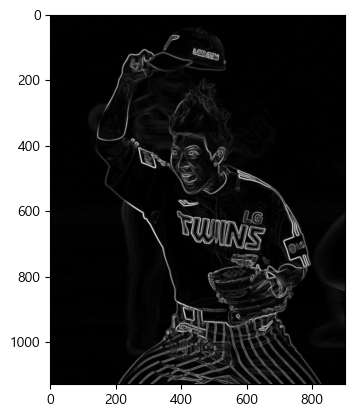

In [14]:
plt.imshow(mag, cmap="gray")
plt.show()

2-3. Implement a function that performs Non-maximum Suppression (NMS):

In [15]:
# a) You are asked to implement an approximated version of NMS by quantizing the gradient
# directions into 8 bins. If a direction is represented by an angle in degrees, we can map the
# direction to the closet representative angle among [0°, 45°,…,315°].

def angle2bins (dir, bin_size):
    dir360 = (dir*(180/np.pi) + 360) % 360 # radius를 0 ~ 360도 사이의 각도로 변환
    len_bins = (360//bin_size) + 1
    bins = np.linspace(0, 360, len_bins)
    centers = (bins[1:]+bins[:-1])/2
    c_dir = bins[np.digitize(dir360, centers)]
    c_dir[c_dir == 360] = 0 # 360e도를 -> 0도로 변환 (circular angle)
    return c_dir

In [16]:
def non_maximum_suppression_dir(mag, dir):
    c_dir = angle2bins(dir, bin_size=45)//45 # 45도 단위로 끊어서 direction을 8개 ticks에 mapping

    # c_dir별 p, r point의 이동좌표 table
    # c) For  instance,  if  the  gradient  direction  is   145°  then  it  is  quantized to   135°.  In  this  case,  the  
    # magnitude at the center position in the window should be compared to the north-west and south-
    # east positions as illustrated in the figure below.
    nmx_table = np.array([[[-1, -1], [1, 1]], [[-1, 0], [1, 0]], [[-1, 1], [1, -1]],
        [[0, -1], [0, 1]], [[0, 1], [0, -1]],
        [[1, -1], [-1, 1]], [[1, 0], [-1, 0]], [[1, 1], [-1, -1]]])
    sprsd_mag = mag.copy()

    rows, cols = c_dir.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            p_move, r_move = nmx_table[int(c_dir[i, j])]
            p = mag[i+p_move[0], j+p_move[1]]
            r = mag[i+r_move[0], j+r_move[1]]
            q = mag[i, j]
            if max(p, r, q) != q: # q point가 magnitude max가 아니라면 mag를 0으로 suppression
                sprsd_mag[i, j] = 0
    
    return sprsd_mag

In [17]:
suppressed = non_maximum_suppression_dir(mag, dir)

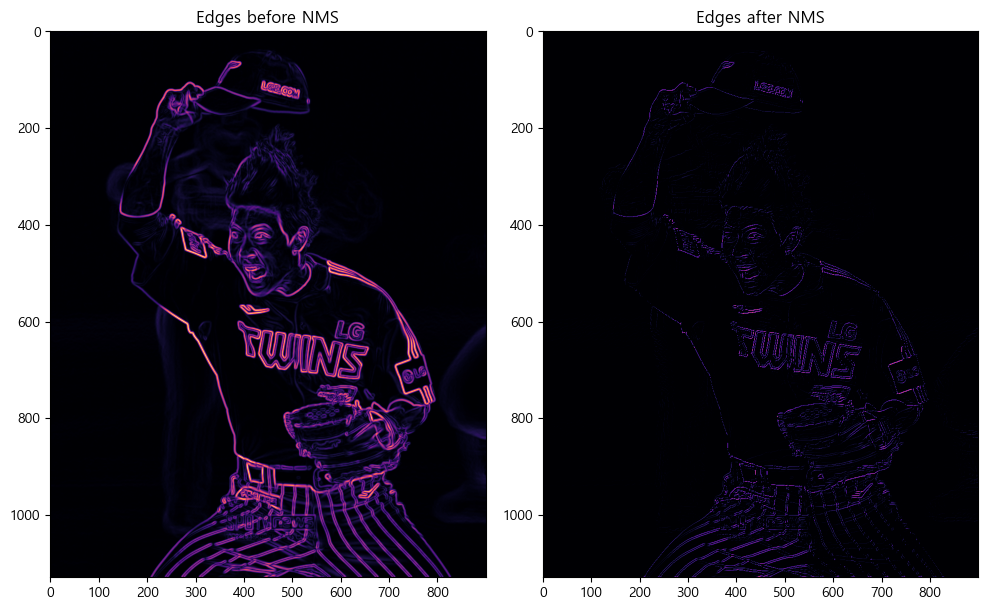

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
ax[0].imshow(mag, cmap="magma")
ax[0].set_title("Edges before NMS")
ax[1].imshow(suppressed, cmap="magma")
ax[1].set_title("Edges after NMS")

plt.tight_layout()
plt.show()

# 이정용의 Edge가 NMS전에는 불규칙한 두께로 나타났지만,
# NMS 후에는 이전에 비해 균일한 두께로 Edge를 Detect하고 있음을 확인할 수 있다.